# **CSCE 670 (Information Storage and Retrieval) Spotlight**

*Submitted by: Shravani Sridhar (430000439)*

*On: Apr 9th, 2020*

# **NimbusML**

NimbusML is a Python machine learning package from Microsoft that provides ML algorithms, transforms, and components. It is a Python bindings framework for ML.NET and provides simple interoperability between ML.NET and Scikit-learn components. 

In this Spotlight notebook, I will showcase NimbusML's NLP features, particularly in sentiment analysis and text processing. These NLP tasks are especially important in search and recommender systems; therefore they are relevant to our course studies.

**Contents:**

*   Installation
      - We will see how to install NimbusML in Google Colab as well as in the terminal using pip.
*   I. Sentiment Analysis
      - We will see how we can use various transforms in NimbusML to perform sentiment analysis with the help of a classifier.
*   II. Removing Stopwords
      - We will explore NimbusML's classes for stopword removal.
*   III. Working with N-grams
      - We will explore in detail transforms in NimbusML that help in feature extraction and working with n-grams.
*   IV. Word Embedding
      - We will see how we can perform word embedding using NimbusML's WordEmbedding class.

**Installation**

The version of NimbusML I am using in my notebook is nimbusml 1.7.0.

To install nimbusml 1.7.0:

(i) in Google Colab:

*!pip install nimbusml*

(ii) using pip in terminal:

*pip install nimbusml*

**I. Sentiment Analysis**

We will see how we can use NimbusML's various transforms to perform sentiment analysis using classifiers. 

(i) First, we will detect sentiments of tweets by building a binary classifier using manually generated Twitter text data. We will do this with the help of the Pandas library.

We will use text as the input (text column) and the sentiments as the output (sentiment column as the label).

In [2]:
import time
import pandas as pd
import numpy as np
import os
from IPython.display import display
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.feature_extraction.text.extractor import Ngram
from nimbusml.linear_model import AveragedPerceptronBinaryClassifier
from nimbusml.decomposition import PcaTransformer
from nimbusml import Pipeline

#Loading training and test data from package
#This Twitter data contains text
trainDataFile = get_dataset('gen_twittertrain').as_filepath()
testDataFile = get_dataset('gen_twittertest').as_filepath()

print("Train data file path: " + str(os.path.basename(trainDataFile)))
print("Test data file path: " + str(os.path.basename(testDataFile)))

trainData = pd.read_csv(trainDataFile, sep = "\t")
testData = pd.read_csv(testDataFile, sep = "\t")

trainData.head()

Train data file path: train-twitter.gen-sample.tsv
Test data file path: test-twitter.gen-sample.tsv


,Sentiment,Text,Label
0,Negative,Oh you are hurting me,0
1,Positive,So long,1
2,Positive,Ths sofa is comfortable,1
3,Negative,The place suck. No?,0
4,Positive,@fakeid &quot;Chillin&quot; I love it!!,1


The above output contains the first 5 entries of the training dataset.

We need to preprocess the data.

NGramFeaturizer is a transform in NimbusML that outputs a bag of counts of sequences of consecutive words, called n-grams, from a given corpus of text. The word counts can then be normalized using the term frequency-inverse document frequency (TF-IDF) method by passing the appropriate parameter to the feature extractor.

For all the examples unless otherwise mentioned, we will use the NGram feature extractor. A feature extractor extracts n-grams from text and converts them to vector form using a dictionary. We will explore this in more detail in subsequent sections.

In [3]:
featurizer = NGramFeaturizer(word_feature_extractor=Ngram(weighting = 'TfIdf')) #Passing the TF-IDF weighting parameter to the feature extractor

#Training the featurizer 
text_transformed = featurizer.fit_transform(trainData["Text"].to_frame()) #The text column is our input

print(text_transformed.shape)
text_transformed.head(5)

(71, 1007)


,Text.Char.<␂>|o|h,Text.Char.o|h|<␠>,Text.Char.h|<␠>|y,Text.Char.<␠>|y|o,Text.Char.y|o|u,Text.Char.o|u|<␠>,Text.Char.u|<␠>|a,Text.Char.<␠>|a|r,Text.Char.a|r|e,Text.Char.r|e|<␠>,Text.Char.e|<␠>|h,Text.Char.<␠>|h|u,Text.Char.h|u|r,Text.Char.u|r|t,Text.Char.r|t|i,Text.Char.t|i|n,Text.Char.i|n|g,Text.Char.n|g|<␠>,Text.Char.g|<␠>|m,Text.Char.<␠>|m|e,Text.Char.m|e|<␃>,Text.Char.<␂>|s|o,Text.Char.s|o|<␠>,Text.Char.o|<␠>|l,Text.Char.<␠>|l|o,Text.Char.l|o|n,Text.Char.o|n|g,Text.Char.n|g|<␃>,Text.Char.<␂>|t|h,Text.Char.t|h|s,Text.Char.h|s|<␠>,Text.Char.s|<␠>|s,Text.Char.<␠>|s|o,Text.Char.s|o|f,Text.Char.o|f|a,Text.Char.f|a|<␠>,Text.Char.a|<␠>|i,Text.Char.<␠>|i|s,Text.Char.i|s|<␠>,Text.Char.s|<␠>|c,...,Text.Word.her,Text.Word.demo?,Text.Word.up,Text.Word.all,Text.Word.night,Text.Word.visit,Text.Word.everyday,Text.Word.icecream,Text.Word.store,Text.Word.nearby,Text.Word.b,Text.Word.subject,Text.Word.ranked,Text.Word.out,Text.Word.week,Text.Word.beautiful,Text.Word.isn't,Text.Word.friday!,Text.Word.tgif,Text.Word.nonononononononono..,Text.Word.we,Text.Word.proud,Text.Word.haven't,Text.Word.prepared,Text.Word.lunch?,Text.Word.trust,Text.Word.try,Text.Word.as,Text.Word.replacement.,Text.Word.should,Text.Word.upset,Text.Word.vocation,Text.Word.flight,Text.Word.late,Text.Word.again,Text.Word.commute,Text.Word.died,Text.Word.cancer,"Text.Word.oh,",Text.Word.finally
0,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.218218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377964,0.377964,0.377964,0.377964,0.377964,0.377964,0.377964,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,0.208514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the above output, all the columns are features from the first 5 entries of the input training text data. We can then train our binary classifier using these features.

Our binary classifier will be an AveragedPerceptron classifier.

In [4]:
ag = AveragedPerceptronBinaryClassifier()
ag.fit(text_transformed, 1 * (trainData["Sentiment"] == "Positive")) #Using the transformed data from above as input to the classifier

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Training calibrator.
Elapsed time: 00:00:00.6856655


AveragedPerceptronBinaryClassifier(averaged=True, averaged_tolerance=0.01,
                                   caching='Auto', decrease_learning_rate=False,
                                   feature=None, initial_weights=None,
                                   initial_weights_diameter=0.0,
                                   l2_regularization=0.0, label=None,
                                   lazy_update=True, learning_rate=1.0,
                                   loss='hinge', normalize='Auto',
                                   number_of_iterations=1, recency_gain=0.0,
                                   recency_gain_multiplicative=False,
                                   reset_weights_after_x_examples=None,
                                   shuffle=True)

Instead of training the featurizer and the classifier separately like we did above, we can also use the NimbusML Pipeline to train them together.

In [5]:
t0 = time.time()

#Training the featurizer and the classifier simultaneously using a pipeline

#We are employing TF-IDF normalization and an L2 regularization parameter of 0.4
ppl = Pipeline([NGramFeaturizer(word_feature_extractor=Ngram(weighting = 'Tf')), PcaTransformer(rank = 100), 
                AveragedPerceptronBinaryClassifier(l2_regularization=0.4, number_of_iterations=5),])

#Fitting the pipeline model using the training dataframe
ppl.fit(trainData["Text"], trainData["Label"]) 

print("Training time: "  + str(round(time.time() - t0, 2)))

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Training calibrator.
Elapsed time: 00:00:00.2393713
Training time: 0.3


We can then test the above pipeline-trained model on the test data.

In [7]:
#Testing the model
metrics, scores = ppl.test(testData["Text"], testData["Label"], output_scores = True)  

print("Performance metrics: ")
display(metrics)
print("\nIndividual scores: ")

#Appending origin text to the score
scores["OriginText"] = testData["Text"]
scores["Sentiment"] = testData["Sentiment"]

display(scores[0:5]) #Displaying the first 5 scores
print("Total runtime: "  + str(round(time.time() - t0, 2)))

Performance metrics: 


,AUC,Accuracy,Positive precision,Positive recall,Negative precision,Negative recall,Log-loss,Log-loss reduction,Test-set entropy (prior Log-Loss/instance),F1 Score,AUPRC
0,0.580762,0.662791,0,0,0.662791,1,1.284392,-0.392864,0.922123,0,0.480434



Individual scores: 


,PredictedLabel,Score,Probability,OriginText,Sentiment
0,0,-0.233300,0.255333,@faketwitterid I am sad,Negative
1,0,-0.270544,0.106594,@wakeup_you It is a very simple twit I created,Negative
2,0,-0.245938,0.193317,@anotherfakeid I would love to see the latest ...,Positive
3,0,-0.269664,0.108991,Oh my ladygaga! I haven't played tennis for 2 ...,Negative
4,0,-0.150562,0.781553,I am heading on a road trip and taking a few d...,Positive


Total runtime: 129.42


Therefore, we have obtained predicted sentiment labels for the first 5 entries of input Twitter test text data using a binary classifier.

The test accuracy obtained is 0.662791 and the AUC (Area Under the Curve) is 0.580762.

(ii) Now we will see how we can do the same Sentiment Analysis using nimbusml to load the data instead of Pandas.

While Pandas saves the entire dataset in memory, nimbusml processes the data by passing a DataFileStream in the training/testing process, thus attaining exponential speed up.

We will again use the manually generated Twitter text data like we did in (i).

In [8]:
#Getting the input file path from package
import os
from nimbusml.datasets import get_dataset
from nimbusml import FileDataStream 

train_file = get_dataset('gen_twittertrain').as_filepath()
test_file = get_dataset('gen_twittertest').as_filepath()

print(os.path.basename(train_file))
print(os.path.basename(test_file))

train-twitter.gen-sample.tsv
test-twitter.gen-sample.tsv


In [9]:
#Generating file schema
data_stream_train = FileDataStream.read_csv(train_file, sep='\t')
data_stream_test = FileDataStream.read_csv(test_file, sep='\t')
data_stream_train.schema

DataSchema([DataColumn(name='Sentiment', type='TX', pos=0),
    DataColumn(name='Text', type='TX', pos=1),
    DataColumn(name='Label', type='I8', pos=2)], header=True,
    sep='\t')

In [10]:
import time
from IPython.display import display
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.feature_extraction.text.extractor import Ngram
from nimbusml.linear_model import AveragedPerceptronBinaryClassifier
from nimbusml.decomposition import PcaTransformer
from nimbusml import Pipeline, FileDataStream

columns = {"features":"Text"}
columns = ["features"]

t0 = time.time()

#Using a pipeline to train the NGramFeaturizer and the binary classifier simultaneously
 
#We are employing TF-IDF normalization and an L2 regularization parameter of 0.3
ppl = Pipeline([NGramFeaturizer(word_feature_extractor=Ngram(weighting = 'TfIdf', ngram_length=2), char_feature_extractor=Ngram(weighting = 'Tf',
                                                                                                                                ngram_length=3),
                                columns = {"features": "Text"}), PcaTransformer(rank = 80, columns = "features"), 
                AveragedPerceptronBinaryClassifier(l2_regularization=0.3, number_of_iterations=3, feature = ["features"], label = "Label"),])

#The model is fitted using the FileDataStream created by the training file name, 
#unlike with Pandas where the model was fit using the entire dataframe
#The data file is then loaded using NimbusML data loader in a streamline, after which the FileDataStream is passed in the pipeline.
ppl.fit(data_stream_train)

print("Training time: "  + str(round(time.time() - t0, 2)))

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Training calibrator.
Elapsed time: 00:00:00.2082816
Training time: 0.24


In general, using nimbusml to load the dataset in this way is much faster than loading the whole dataset into memory beforehand, like we do using Pandas, since all the processes have been optimized to boost performance.

Now we can test the above model on the test data.

In [12]:
#Testing the pipeline-trained model using the FileDataStream of the test file
metrics, scores = ppl.test(data_stream_test, output_scores = True)

print("Performance metrics: ")
display(metrics)
print("\nIndividual scores: ")

display(scores[0:5]) #Displaying the first 5 scores
print("Total runtime: " + str(round(time.time() - t0)))

Performance metrics: 


,AUC,Accuracy,Positive precision,Positive recall,Negative precision,Negative recall,Log-loss,Log-loss reduction,Test-set entropy (prior Log-Loss/instance),F1 Score,AUPRC
0,0.550514,0.627907,0,0,0.650602,0.947368,1.123148,-0.218002,0.922123,0,0.340803



Individual scores: 


,PredictedLabel,Score,Probability
0,0,-0.179711,0.032265
1,0,-0.046403,0.600952
2,0,-0.105915,0.215577
3,0,-0.131839,0.115820
4,0,-0.088173,0.313349


Total runtime: 30


Therefore, we have the predicted sentiment labels and scores of the first 5 entries of input Twitter test text data using a binary classifier, using the help of nimbusml to load and process data. 

We also obtained a test accuracy of 0.627907 and an AUC of 0.550514.

(iii) We will now see how we can combine Scikit-learn with nimbusml to develop a binary classifier that can perform Sentiment Analysis.

In particular, we will use a binary classifier to identify if a comment on a Wikipedia talk webpage is a personal attack or not.

We will use the Wikipedia Detox dataset, and take the comment column as the input and the (sentiment) label column as the label.

We will create two models for the purpose of demonstration. Like in (ii), the data will be loaded and processed using nimbusml's DataFileStream.

Our first model will be based on an sklearn pipeline with NimbusML's NGramFeaturizer.

In [13]:
import numpy as np
import time
import sklearn
import os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text.extractor import Ngram
from nimbusml.feature_extraction.text import NGramFeaturizer
from sklearn.feature_extraction.text import TfidfVectorizer as sklearn_TfidfVectorizer
from sklearn.decomposition import TruncatedSVD as sklearn_TruncatedSVD
from sklearn.pipeline import Pipeline as sklearn_ppl
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as sk_auc

#Function to plot the ROC (Receiver Operating Characteristic) curve
def plot_roc_score(label_test, score):
    x, y, _ = roc_curve(label_test, score)
    roc_auc = sk_auc(x, y)
    
    plt.figure()
    lw = 2
    plt.plot(x, y, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate') #the x-axis represents the false positive rate
    plt.ylabel('True Positive Rate') #the y-axis represents the true positive rate
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

#Obtaining input data file path from the package
Train_file = get_dataset('wiki_detox_train').as_filepath()
Test_file = get_dataset('wiki_detox_test').as_filepath()

print(os.path.basename(Train_file))
print(os.path.basename(Test_file))

train-250.wikipedia.sample.tsv
test.wikipedia.sample.tsv


In [14]:
#Loading the data
dataTrain = pd.read_csv(Train_file, sep = "\t")
dataTest = pd.read_csv(Test_file, sep = "\t")

dataTrain.head()

,Sentiment,SentimentText
0,1,"==RUDE== Dude, you are rude upload that carl..."
1,1,== OK! == IM GOING TO VANDALIZE WILD ONES W...
2,1,"Stop trolling, zapatancas, calling me a lia..."
3,1,==You're cool== You seem like a really cool...
4,1,::::: Why are you threatening me? I'm not bei...


The above output shows the first 5 entries of the training dataset.

In [15]:
t0 = time.time()

featurizer = NGramFeaturizer(word_feature_extractor=Ngram()) #Creating our nimbusml featurizer

#Using sklearn's Truncated SVD (Singular Value Decomposition) for linear dimensionality reduction
svd = sklearn_TruncatedSVD(random_state = 1, n_components = 400)  

#Using logistic regression from sklearn as our binary classifier
lr = sklearn.linear_model.LogisticRegression()

#Creating an sklearn pipeline using the above
sk_ppl = sklearn_ppl([("featurizer",featurizer), ("svd",svd), ("lr", lr)]) 

#Training the above pipeline
sk_ppl.fit(dataTrain[["SentimentText"]], dataTrain["Sentiment"]) 

train_time_sec = time.time() - t0
print("Training time: " + str(round(train_time_sec,2)) + "s")

Training time: 1.64s


In [16]:
t0 = time.time()

#Testing the pipeline-trained model on the test data
Y_pred = sk_ppl.predict(dataTest["SentimentText"].to_frame()) 
Y_prob = sk_ppl.predict_proba(dataTest["SentimentText"].to_frame())

test_time_sec = time.time() - t0
print("Testing time: " + str(round(test_time_sec,2)) + "s")

Testing time: 1.02s


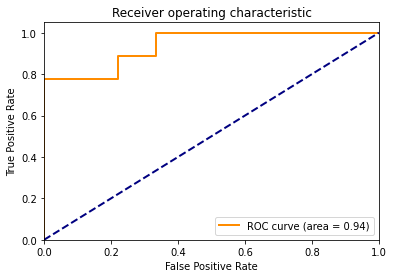

In [17]:
#Plotting the ROC (Receiver Operating Characteristic) curve based on the test data
plot_roc_score(dataTest["Sentiment"], Y_prob[:,1]);

Our second model will be based on a pure nimbusml pipeline with NimbusML's NGramFeaturizer, WordEmbedding, and FastLinearBinaryClassifier.

Our binary classifier will be a FastLinearBinaryClassifier. 

NimbusML's WordEmbedding is based on a pre-trained DNN model to generate word embeddings for given corps. NimbusML supports many kinds of word embedding models; we will be using a Sentiment-Specific Word Embedding (SSWE) model. That is, the pre-trained DNN model our word embedding will be based on is the SSWE model.

In [18]:
import time
from nimbusml.linear_model import FastLinearBinaryClassifier
from nimbusml.feature_extraction.text import WordEmbedding
from nimbusml import Pipeline, FileDataStream

#Creating the featurizer, which will convert the input text into a format acceptable by the SSWE 
featurizer = NGramFeaturizer(columns=['SentimentText'], output_tokens_column_name='SentimentText_TransformedText') 
#The column containing the output tokens will be named 'SentimentText_TransformedText'

#Creating our word embedding model (SSWE)
glove = WordEmbedding(columns='SentimentText_TransformedText', model_kind='SentimentSpecificWordEmbedding') 

ppl = Pipeline([featurizer, glove]) #Creating our nimbusml pipeline using the above
ppl.fit_transform(dataTrain[["SentimentText"]])[0:3] #Training the pipeline

,SentimentText.Char.<␂>|<␠>|<␠>,SentimentText.Char.<␠>|<␠>|=,SentimentText.Char.<␠>|=|=,SentimentText.Char.=|=|r,SentimentText.Char.=|r|u,SentimentText.Char.r|u|d,SentimentText.Char.u|d|e,SentimentText.Char.d|e|=,SentimentText.Char.e|=|=,SentimentText.Char.=|=|<␠>,SentimentText.Char.=|<␠>|d,SentimentText.Char.<␠>|d|u,SentimentText.Char.d|u|d,"SentimentText.Char.d|e|,","SentimentText.Char.e|,|<␠>","SentimentText.Char.,|<␠>|y",SentimentText.Char.<␠>|y|o,SentimentText.Char.y|o|u,SentimentText.Char.o|u|<␠>,SentimentText.Char.u|<␠>|a,SentimentText.Char.<␠>|a|r,SentimentText.Char.a|r|e,SentimentText.Char.r|e|<␠>,SentimentText.Char.e|<␠>|r,SentimentText.Char.<␠>|r|u,SentimentText.Char.d|e|<␠>,SentimentText.Char.e|<␠>|u,SentimentText.Char.<␠>|u|p,SentimentText.Char.u|p|l,SentimentText.Char.p|l|o,SentimentText.Char.l|o|a,SentimentText.Char.o|a|d,SentimentText.Char.a|d|<␠>,SentimentText.Char.d|<␠>|t,SentimentText.Char.<␠>|t|h,SentimentText.Char.t|h|a,SentimentText.Char.h|a|t,SentimentText.Char.a|t|<␠>,SentimentText.Char.t|<␠>|c,SentimentText.Char.<␠>|c|a,...,SentimentText_TransformedText.110,SentimentText_TransformedText.111,SentimentText_TransformedText.112,SentimentText_TransformedText.113,SentimentText_TransformedText.114,SentimentText_TransformedText.115,SentimentText_TransformedText.116,SentimentText_TransformedText.117,SentimentText_TransformedText.118,SentimentText_TransformedText.119,SentimentText_TransformedText.120,SentimentText_TransformedText.121,SentimentText_TransformedText.122,SentimentText_TransformedText.123,SentimentText_TransformedText.124,SentimentText_TransformedText.125,SentimentText_TransformedText.126,SentimentText_TransformedText.127,SentimentText_TransformedText.128,SentimentText_TransformedText.129,SentimentText_TransformedText.130,SentimentText_TransformedText.131,SentimentText_TransformedText.132,SentimentText_TransformedText.133,SentimentText_TransformedText.134,SentimentText_TransformedText.135,SentimentText_TransformedText.136,SentimentText_TransformedText.137,SentimentText_TransformedText.138,SentimentText_TransformedText.139,SentimentText_TransformedText.140,SentimentText_TransformedText.141,SentimentText_TransformedText.142,SentimentText_TransformedText.143,SentimentText_TransformedText.144,SentimentText_TransformedText.145,SentimentText_TransformedText.146,SentimentText_TransformedText.147,SentimentText_TransformedText.148,SentimentText_TransformedText.149
0,0.112509,0.112509,0.112509,0.112509,0.112509,0.225018,0.337526,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.225018,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,0.112509,...,1.462784,0.528055,0.698277,0.249722,0.855730,0.858960,0.052535,0.637218,0.302744,0.641849,1.275095,1.569134,1.453716,1.825948,2.058919,0.825440,0.154269,1.684076,0.844316,0.474553,1.962824,-0.341685,0.574575,1.473381,1.423488,1.290106,0.760995,0.347281,0.938264,2.886388,-0.463254,-0.081983,1.956025,0.483862,1.145274,0.730155,1.072578,1.693832,-0.134111,3.389347
1,0.123091,0.123091,0.246183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.246183,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123091,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.904996,1.730018,-0.507464,0.444537,0.542321,-0.166392,0.135847,0.147397,0.635437,0.183642,0.571249,1.210280,1.532342,1.225561,2.105577,0.654956,0.489232,0.486822,0.041106,0.056376,1.771506,1.859128,1.963889,1.518326,1.054131,0.818986,0.275295,1.228935,0.431228,1.252122,-0.529051,-0.036032,0.686052,0.628498,0.456804,0.624132,2.142290,1.189043,-0.230683,2.423379
2,0.036936,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

The above output contains the output from the NGramFeaturizer, i.e, the weighted word/sequence count. These columns are given as input to the SSWE model as an array of words. The above output contains the output of SSWE as well.

Now we will create a pipeline for the full classification.

In [19]:
#Generating the training and test data file stream    
data_stream_train = FileDataStream.read_csv(Train_file, sep='\t',collapse=False)
data_stream_test = FileDataStream.read_csv(Test_file, sep='\t',collapse=False)

#Creating a pipeline using the NGramFeaturizer, WordEmbedding, and FastLinearBinaryClassifier transforms
pipeline = Pipeline([NGramFeaturizer(word_feature_extractor=Ngram(), output_tokens_column_name='SentimentText_TransformedText', columns=['SentimentText']),
                     WordEmbedding(columns = "SentimentText_TransformedText"), 
                     FastLinearBinaryClassifier(feature = ["SentimentText_TransformedText"], label = 'Sentiment')])

#Training the pipeline
pipeline.fit(data_stream_train)  

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Using 1 thread to train.
Automatically choosing a check frequency of 1.
Auto-tuning parameters: maxIterations = 6300.
Auto-tuning parameters: L2 = 2.667734E-05.
Auto-tuning parameters: L1Threshold (L1/L2) = 0.25.
Using best model from iteration 2591.
Not training a calibrator because it is not needed.
Elapsed time: 00:00:01.0356104


In [20]:
#Testing the pipeline on our test data
metrics, scores = pipeline.test(data_stream_test,'Sentiment', output_scores = True)
metrics

,AUC,Accuracy,Positive precision,Positive recall,Negative precision,Negative recall,Log-loss,Log-loss reduction,Test-set entropy (prior Log-Loss/instance),F1 Score,AUPRC
0,0.938272,0.833333,0.8,0.888889,0.875,0.777778,0.564218,0.435782,1,0.842105,0.958791


Therefore, we have obtained a test accuracy of 0.833333 and an AUC of 0.938272 using our FastLinearBinaryClassifier to detect whether a comment on a Wikipedia talk page is a personal comment or not, using a pure nimbusml pipeline with the SSWE model.

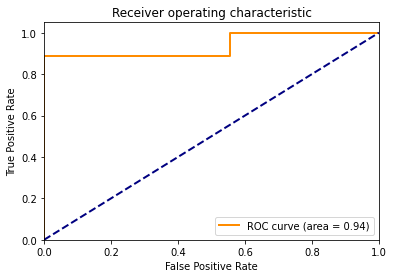

In [21]:
#Plotting the ROC (Receiver Operating Characteristic) curve based on the test data
plot_roc_score(dataTest["Sentiment"], scores["Probability"]);

(iv) NimbusML provides a Sentiment class for scoring natural language text and measuring the probability that the sentiments of text are positive.

The syntax is as follows: *Sentiment(columns=None, **params)*

The 'columns' parameter specifies a dictionary of key-value pairs, where key is the output column name and value is a list of input column names.

'**params' denotes a set of additional arguments sent to the compute engine.

The Sentiment transform outputs the sentiment prediction as a score between 0 and 1, where 0 is a negative sentiment and 1 is a positive sentiment. The model was trained on Twitter sentiment data and currently supports only English.

**II. Removing Stopwords**

Now we will see how we can use NimbusML to remove stopwords from input text.

NimbusML's CustomStopWordsRemover class removes a list of stopwords that the user specifies.

The syntax is as follows: *CustomStopWordsRemover(stopword = None, **params)*

The 'stopword' parameter is a list of stopwords to be removed, while '**params' specifies a set of additional arguments sent to the compute engine.

Below is an example using the CustomStopWordsRemover class. The NGramFeaturizer can help us use the class. 

We will use the Wikipedia Detox dataset.

In [33]:
from nimbusml import FileDataStream
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.feature_extraction.text.extractor import Ngram
from nimbusml.feature_extraction.text.stopwords import CustomStopWordsRemover

#Obtaining data input as a FileDataStream
path = get_dataset('wiki_detox_train').as_filepath()

data = FileDataStream.read_csv(path, sep='\t')
print(data.head())
print("\n")

#Creating the featurizer
xf = NGramFeaturizer(word_feature_extractor=Ngram(),
                        stop_words_remover=CustomStopWordsRemover(['!','$','%','&','\'','\'d']), #Specifying the list of stopwords to be removed
                        columns={'features': ['SentimentText']})

features = xf.fit_transform(data)

#Printing the extracted features for the first 5 entries of the training dataset
print(features.head())

   Sentiment                                      SentimentText
0          1  ==RUDE== Dude, you are rude upload that carl p...
1          1  == OK! ==  IM GOING TO VANDALIZE WILD ONES WIK...
2          1  Stop trolling, zapatancas, calling me a liar m...
3          1  ==You're cool==  You seem like a really cool g...
4          1  ::::: Why are you threatening me? I'm not bein...


   Sentiment  ... features.Word.award.
0          1  ...                  0.0
1          1  ...                  0.0
2          1  ...                  0.0
3          1  ...                  0.0
4          1  ...                  0.0

[5 rows x 8602 columns]


NimbusML's PredefinedStopWordsRemover class is used to remove a predefined list of stopwords from text.

The syntax is as follows: *PredefinedStopWordsRemover(**params)*

'**params' is a set of additional arguments sent to the compute engine.

Below is an example using the PredefinedStopWordsRemover class. The NGramFeaturizer can help us use the class. 

We will again use the Wikipedia Detox dataset.


In [34]:
from nimbusml import FileDataStream
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.feature_extraction.text.extractor import Ngram

#Obtaining data input as a FileDataStream
path = get_dataset("wiki_detox_train").as_filepath()

data = FileDataStream.read_csv(path, sep='\t')
print(data.head())
print("\n")

#Creating the featurizer
xf = NGramFeaturizer(
       word_feature_extractor=Ngram(),
       columns={
           'features': ['SentimentText']})

features = xf.fit_transform(data)

#Printing the extracted features for the first 5 entries of the training dataset
print(features.head())

   Sentiment                                      SentimentText
0          1  ==RUDE== Dude, you are rude upload that carl p...
1          1  == OK! ==  IM GOING TO VANDALIZE WILD ONES WIK...
2          1  Stop trolling, zapatancas, calling me a liar m...
3          1  ==You're cool==  You seem like a really cool g...
4          1  ::::: Why are you threatening me? I'm not bein...


   Sentiment  ... features.Word.award.
0          1  ...                  0.0
1          1  ...                  0.0
2          1  ...                  0.0
3          1  ...                  0.0
4          1  ...                  0.0

[5 rows x 8651 columns]


**III. Working with N-grams**

NGramFeaturizer, as discussed previously, is a transform that outputs a bag of counts of sequences of consecutive words, or n-grams, from a corpus of text. It can extract features, i.e, the n-grams, in one of two ways. We will see these two methods here.

(i) NGram class

NimbusML's NGram class can be used to extract n-grams from text and then convert them to vector form using a dictionary.

We had been using the NGram feature extractor in the examples thus far.

The syntax is as follows: *Ngram(ngram_length=1, skip_length=0, all_lengths=True, max_num_terms=[10000000], weighting='Tf', **params)*

The 'ngram_length' parameter denotes the length of the n-gram we want.

The 'skip_length' parameter denotes the maximum number of tokens to skip when constructing the n-gram.

The 'all_lengths' parameter denotes whether we want to include all n-gram lengths up to the specified 'ngram_length' or only the 'ngram_length'.

The 'max_num_terms' parameter denotes the maximum number of n-grams we want to store in the dictionary.

The 'weighting' parameter specifies the weighting criteria.

'**params' specifies a set of additional arguments sent to the compute engine.

Below is an example that demonstrates use of the NGram class, again using the Wikipedia Detox dataset.

In [35]:
from nimbusml import FileDataStream
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.feature_extraction.text.extractor import Ngram

#Obtaining data input as a FileDataStream
path = get_dataset("wiki_detox_train").as_filepath()

data = FileDataStream.read_csv(path, sep='\t')
print(data.head())
print("\n")

#Creating the featurizer and specifying it to extract n-grams using the NGram class
xf = NGramFeaturizer(
word_feature_extractor=Ngram(),
columns={'features': ['SentimentText']})
#The 'columns' parameter denotes the name of the output column

features = xf.fit_transform(data)

#Printing the extracted features for the first 5 entries of the training dataset
print(features.head())

   Sentiment                                      SentimentText
0          1  ==RUDE== Dude, you are rude upload that carl p...
1          1  == OK! ==  IM GOING TO VANDALIZE WILD ONES WIK...
2          1  Stop trolling, zapatancas, calling me a liar m...
3          1  ==You're cool==  You seem like a really cool g...
4          1  ::::: Why are you threatening me? I'm not bein...


   Sentiment  ... features.Word.award.
0          1  ...                  0.0
1          1  ...                  0.0
2          1  ...                  0.0
3          1  ...                  0.0
4          1  ...                  0.0

[5 rows x 8651 columns]


(ii) NGramHash class

The NGramHash class in NimbusML is also used to extract n-grams from text and convert them to vector form using a dictionary, but using hashing.

The syntax is as follows: *NgramHash(number_of_bits=16, ngram_length=1, skip_length=0, all_lengths=True, seed=314489979, ordered=True, maximum_number_of_inverts=0, **params)*

The parameter 'number_of_bits' denotes the number of bits to hash into (between 1 and 30, inclusive).

The 'seed' parameter specifies the hashing seed value.

The 'ordered' parameter denotes whether the position of each source column should be included in the hash when there are multiple source columns.

The 'maximum_number_of_inverts' denotes the value to which we are limiting the number of keys used to generate the slot. 0 means no invert hashing and -1 means no limit.

The remaining parameters mean the same as in the NGram class.

Below is an example that demonstrates use of the NGramHash class, again using the Wikipedia Detox dataset.



In [36]:
from nimbusml import FileDataStream
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.feature_extraction.text.extractor import NgramHash

#Obtaining data input as a FileDataStream
path = get_dataset('wiki_detox_train').as_filepath()

data = FileDataStream.read_csv(path, sep='\t')
print(data.head())
print("\n")

#Creating the featurizer and specifying it to extract n-grams using the NGramHash class
xf = NGramFeaturizer(word_feature_extractor=NgramHash(),
                        columns=['SentimentText'])
#The 'columns' parameter denotes the name of the output column

features = xf.fit_transform(data)

#Printing the extracted features for the first 5 entries of the training dataset
print(features.head())

   Sentiment                                      SentimentText
0          1  ==RUDE== Dude, you are rude upload that carl p...
1          1  == OK! ==  IM GOING TO VANDALIZE WILD ONES WIK...
2          1  Stop trolling, zapatancas, calling me a liar m...
3          1  ==You're cool==  You seem like a really cool g...
4          1  ::::: Why are you threatening me? I'm not bein...


   Sentiment  ...  SentimentText.70837
0          1  ...                  0.0
1          1  ...                  0.0
2          1  ...                  0.0
3          1  ...                  0.0
4          1  ...                  0.0

[5 rows x 70839 columns]


Now we will finally inspect the NGramFeaturizer class itself.

The syntax is as follows: *NGramFeaturizer(language='English', stop_words_remover=None, text_case='Lower', keep_diacritics=False, keep_punctuations=True, keep_numbers=True, output_tokens_column_name=None, dictionary=None, word_feature_extractor={'Name': 'NGram', 'Settings': {'NgramLength': 1, 'SkipLength': 0, 'AllLengths': True, 'MaxNumTerms': [10000000], 'Weighting': 'Tf'}}, char_feature_extractor={'Name': 'NGram', 'Settings': {'NgramLength': 3, 'SkipLength': 0, 'AllLengths': False, 'MaxNumTerms': [10000000], 'Weighting': 'Tf'}}, vector_normalizer='L2', columns=None, **params)*

The 'columns' parameter specifies a dictionary of key-value pairs, where key is the output column name and value is a list of input column names.

The 'language' parameter specifies the language used in the dataset.

The 'stop_words_remover' parameter denotes the stopword remover we want to use, i.e, whether CustomStopWordsRemover, PredefinedStopWordsRemover, or neither.

The 'text_case' parameter specifies the text casing.

The 'keep_diacritics' parameter denotes whether to retain the diacritical marks or not.

The 'keep_punctuations' parameter denotes whether we want to keep punctuation or not.

The 'keep_numbers' parameter denotes whether we want to keep or remove numbers.

The 'output_tokens_column_name' parameter denotes the name of the column containing the transformed text tokens.

The 'dictionary' parameter denotes a dictionary of whitelisted terms.

The parameter 'word_feature_extractor' denotes the word feature extraction arguments, i.e whether we want to use the NGram class or the NGramHash class for feature extraction.

The parameter 'char_feature_extractor' denotes the character feature extraction arguments. Again this can be done using the NGram class or the NGramHash class.

The parameter 'vector_normalizer' specifies which norm we want to use to normalize rows individually by rescaling them.

'**params' denotes the set of additional arguments sent to the compute engine.

We will use an example from above to demonstrate how we can use this class to extract n-grams from text using the NGram class.

We will again use the Wikipedia Detox dataset.

In [37]:
from nimbusml import FileDataStream
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text import NGramFeaturizer
from nimbusml.feature_extraction.text.extractor import Ngram

#Obtaining data input as a FileDataStream
path = get_dataset("wiki_detox_train").as_filepath()

data = FileDataStream.read_csv(path, sep='\t')
print(data.head())
print("\n")

#Creating the featurizer
xf = NGramFeaturizer(
       word_feature_extractor=Ngram(),
       columns={
           'features': ['SentimentText']})

features = xf.fit_transform(data)

#Printing the extracted features for the first 5 entries of the training dataset
print(features.head())

   Sentiment                                      SentimentText
0          1  ==RUDE== Dude, you are rude upload that carl p...
1          1  == OK! ==  IM GOING TO VANDALIZE WILD ONES WIK...
2          1  Stop trolling, zapatancas, calling me a liar m...
3          1  ==You're cool==  You seem like a really cool g...
4          1  ::::: Why are you threatening me? I'm not bein...


   Sentiment  ... features.Word.award.
0          1  ...                  0.0
1          1  ...                  0.0
2          1  ...                  0.0
3          1  ...                  0.0
4          1  ...                  0.0

[5 rows x 8651 columns]


**IV. Word Embedding**

We will see how NimbusML provides support for word embedding. The WordEmbedding class can be used to convert the vectors of text tokens obtained from the featurizer into sentence vectors using a pre-trained model. In our Sentiment Analysis section, we had used the SSWE model for word embedding.

The syntax is as follows: *WordEmbedding(model_kind='SentimentSpecificWordEmbedding', custom_lookup_table=None, columns=None, **params)*

The 'model_kind' parameter specifies which pre-trained DNN model we want to use for our word embedding, i.e, to create our vocabulary. Options include SSWE, GloVe50D, GloVeTwitter100D, and FastTextWikipedia300D.

The 'custom_lookup_table' parameter denotes a filename for a custom word embedding model.

'**params' denotes the set of additional arguments sent to the compute engine.

Below is an example that demonstrates use of the WordEmbedding class, again using the Wikipedia Detox dataset.

In [38]:
from nimbusml import FileDataStream, Pipeline
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text import NGramFeaturizer, WordEmbedding
from nimbusml.feature_extraction.text.extractor import Ngram

#Obtaining data input as a FileDataStream
path = get_dataset('wiki_detox_train').as_filepath()
data = FileDataStream.read_csv(path, sep='\t')
print(data.head())
print("\n")
  
#Creating the pipeline using NGramFeaturizer and WordEmbedding
pipeline = Pipeline([
       NGramFeaturizer(word_feature_extractor=Ngram(), output_tokens_column_name='ngram_TransformedText',
                       columns={'ngram': ['SentimentText']}),

       WordEmbedding(columns='ngram_TransformedText') #In this example, we are not specifying any specific pre-trained DNN model
   ])

features = pipeline.fit_transform(data)

#Printing the extracted features for the first 5 entries of the training dataset
print(features.head())

   Sentiment                                      SentimentText
0          1  ==RUDE== Dude, you are rude upload that carl p...
1          1  == OK! ==  IM GOING TO VANDALIZE WILD ONES WIK...
2          1  Stop trolling, zapatancas, calling me a liar m...
3          1  ==You're cool==  You seem like a really cool g...
4          1  ::::: Why are you threatening me? I'm not bein...


   Sentiment  ... ngram.Word.award.
0          1  ...               0.0
1          1  ...               0.0
2          1  ...               0.0
3          1  ...               0.0
4          1  ...               0.0

[5 rows x 8801 columns]


Thus, to conclude, we have seen an in-depth exploration of NimbusML's NLP features in sentiment analysis and text processing, particularly in word feature extraction, stopword removal, and word embedding.